# Price stock tendency prediction

## Setup

In [44]:
%load_ext autoreload
%autoreload 2

from notebook_config import setup_notebook
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

setup_notebook()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from tqdm.notebook import trange, tqdm

from helpers.data_helper import *

In [9]:
DATA_PATH = '../data/'
quotation = 'AMZN'
FILE_SUFFIX = '.txt'
price_column = 'Close'

In [10]:
from datasets.stocks_data_wrapper import StocksDataWrapper
data_wrapper = StocksDataWrapper.read_from(f"{DATA_PATH}{quotation}{FILE_SUFFIX}", compute_features=True, predict_n=1, thresh_diff=0.005, normalize=True)
data_wrapper.head()

,Date,Open,High,Low,Close,Volume,Adjusted,LowLen,RSI(14),GAP,...,SMA(10),SMA(20),EMA(14),EMA_Diff,SMA(20) - SMA(10),Difference,PercentageDiff,Tendency,NextPrice,Next
0,2007-02-21,0.001680,0.000922,0.001808,0.001782,0.035062,0.001782,0.001471,0.639459,0.001666,...,0.000509,0.000046,0.000349,0.421360,0.545121,0.443937,0.306549,lower,0.001707,lower
1,2007-02-22,0.001740,0.001115,0.001799,0.001707,0.039100,0.001707,0.000599,0.600019,0.000729,...,0.000570,0.000103,0.000406,0.420483,0.545077,0.443913,0.305847,lower,0.001645,lower
2,2007-02-23,0.001626,0.000888,0.001755,0.001645,0.044622,0.001645,0.000218,0.566754,0.000000,...,0.000619,0.000160,0.000447,0.419791,0.545127,0.444008,0.308202,lower,0.001673,stay
3,2007-02-26,0.001586,0.000888,0.001657,0.001673,0.030488,0.001673,0.002507,0.575544,0.000416,...,0.000684,0.000221,0.000487,0.419730,0.545085,0.444765,0.327879,stay,0.001087,lower
4,2007-02-27,0.001395,0.000700,0.001188,0.001087,0.077038,0.001087,0.000273,0.325640,0.003592,...,0.000683,0.000243,0.000439,0.416054,0.545293,0.439680,0.195493,lower,0.001175,higher


In [11]:
data_wrapper.df.isnull().values.any()

False

### Plots

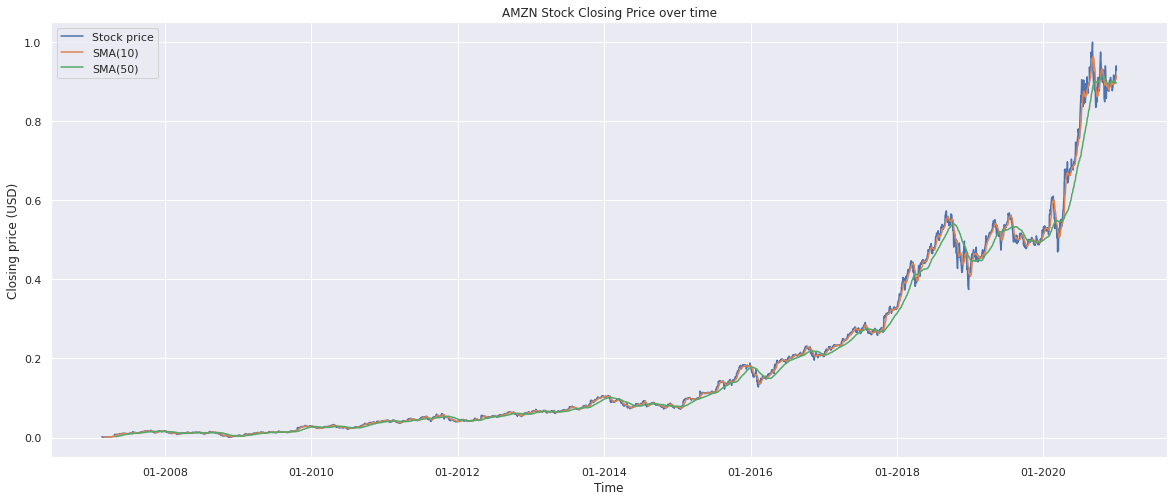

In [12]:
from helpers.plots_helper import plot_prices

ax = plot_prices(data_wrapper['Date'], data_wrapper[price_column], quotation_name=quotation, ma_values=[10,50])

<AxesSubplot:>

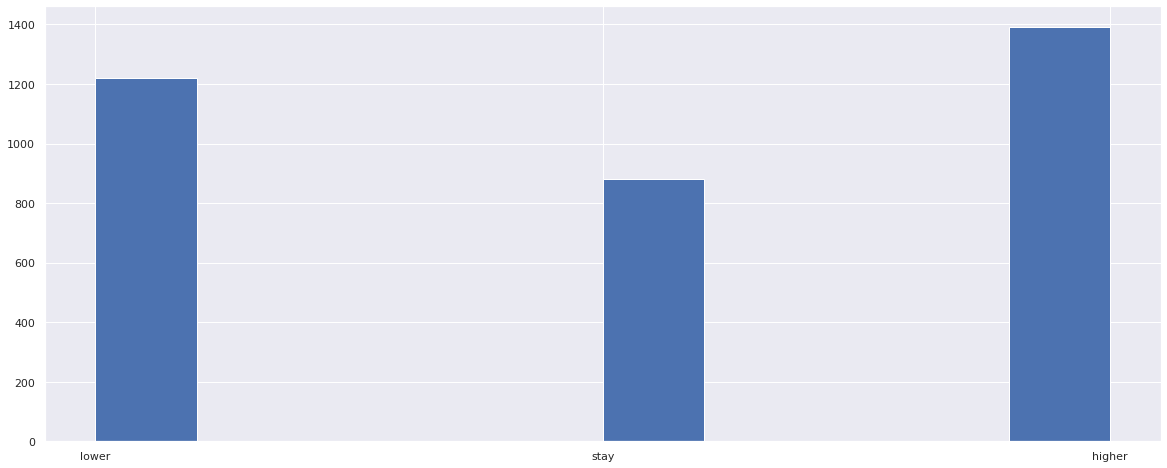

In [13]:
data_wrapper['Next'].hist()

### ML Data preparation

In [14]:
data_columns = ['Close', 'PercentageDiff', f"RSI(14)", 'Volume', 'LowLen']

X_train, X_test, y_train, y_test = data_wrapper.get_datasets(n_splits=1, val_size=0.3, 
                                                             y_column='Next', 
                                                             features_list=data_columns)

## Classifier and evaluation

In [15]:
from sklearn.utils.class_weight import compute_class_weight

def compute_class_weights(y_train):
    class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
    # format as dict
    return {c:w for c,w in zip(np.unique(y_train), class_weights)}

USE_CLASS_WEIGHTS = True

if USE_CLASS_WEIGHTS:
    class_weights=compute_class_weights(y_train)
else:
    class_weights = None

d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2], y=[0 0 1 ... 0 2 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


### Grid Search

In [16]:
from sklearn.model_selection import TimeSeriesSplit
# build the time series split for cross validation so no data leakage
tscv = TimeSeriesSplit(n_splits=5)

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

PERFORM_GRID_SEARCH = False

# default parameters
best_params = {'DTree': {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 5}, 'RandomForest': {'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500}, 'SVM': {'C': 100.0, 'gamma': 'scale', 'kernel': 'rbf'}, 'LR': {'penalty': 'l2', 'C': 1.0}}

param_grid = {
    'DTree':{
        'criterion':('entropy', 'gini'),
        'max_depth':[1,2,3,5,8,10],
        'min_samples_leaf':[1,2,3,5,10,15],
    },
    'RandomForest':{
        'criterion':('entropy', 'gini'),
        'n_estimators':[50,100,200,500],
        'max_depth':[2,3,5,8,10],
        'min_samples_leaf':[1,2,3,5,10,15],
        'max_features':['auto', 'sqrt', 'log2'], 
    },
    'SVM':{
        'C':[1e-3, 1e-2, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0, 100.0],
        'kernel':('linear', 'poly', 'rbf'),
        'gamma':('scale', 'auto'),
    },
    'LR':
    {
        'penalty':('none', 'l2'),
        'C':[0.5, 1.0]
    },   
    
}

def compute_grid_search(param_grid, X_train):
    tscv = TimeSeriesSplit(n_splits=5)
    best_params = {}
    
    print("Performing grid search...")
    dtree = DecisionTreeClassifier(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(dtree, param_grid['DTree'], cv=tscv.split(X_train), n_jobs=6)
    clf.fit(X_train, y_train)
    best_params['DTree'] = clf.best_params_

    random_forest = RandomForestClassifier(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(random_forest, param_grid['RandomForest'], cv=tscv.split(X_train), n_jobs=6)
    clf.fit(X_train, y_train)
    best_params['RandomForest'] = clf.best_params_

    
    svm = SVC(random_state=42, class_weight=class_weights, cache_size=4096)
    clf = GridSearchCV(svm, param_grid['SVM'], cv=tscv.split(X_train), n_jobs=6, verbose=30)
    clf.fit(X_train, y_train)
    best_params['SVM'] = clf.best_params_
    
    lr = LogisticRegression(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(lr, param_grid['LR'], cv=tscv.split(X_train), n_jobs=6)
    clf.fit(X_train, y_train)
    best_params['LR'] = clf.best_params_
    return best_params

if PERFORM_GRID_SEARCH:
    best_params = compute_grid_search(param_grid, X_train)
    print(best_params)

### Classifiers

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

clf_dict = {}

clf_dict['DTree'] = DecisionTreeClassifier(**best_params['DTree'], random_state=42, class_weight=class_weights)
clf_dict['RandomForest'] = RandomForestClassifier(**best_params['RandomForest'], random_state=42, class_weight=class_weights)
clf_dict['SVM'] = SVC(**best_params['SVM'], class_weight=class_weights)
clf_dict['LR'] = LogisticRegression(**best_params['LR'], class_weight=class_weights)

### Training

In [25]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix, f1_score

def train_evaluate_classifiers(clf_dict, X_train, y_train, X_test, y_test):
    clf_metrics = {}
    for clf_label, clf in clf_dict.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_train)
        print(f"Training accuracy : {accuracy_score(y_pred, y_train)}")
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_pred, y_test)
        f1 = f1_score(y_pred, y_test, average='weighted')

        print(f"[{clf_label}] Accuracy : {accuracy:.2f}, F1 : {f1:.2f}")
        plot_confusion_matrix(clf, X_test, y_test, normalize='true')
        clf_metrics[clf_label] = {'acc':accuracy, 'f1':f1}
        
    return clf_metrics

### Pipeline

d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2], y=[0 0 0 ... 1 2 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Performing grid search...
Fitting 5 folds for each of 54 candidates, totalling 270 fits


d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'DTree': {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1}, 'RandomForest': {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 10, 'n_estimators': 50}, 'SVM': {'C': 0.001, 'gamma': 'scale', 'kernel': 'linear'}, 'LR': {'C': 0.5, 'penalty': 'none'}}
Training accuracy : 0.5431846090871879
[DTree] Accuracy : 0.27, F1 : 0.30
Training accuracy : 0.6942284076954564
[RandomForest] Accuracy : 0.32, F1 : 0.32
Training accuracy : 0.4449447400736799
[SVM] Accuracy : 0.39, F1 : 0.46


d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training accuracy : 0.3622595169873107
[LR] Accuracy : 0.28, F1 : 0.34
Performing grid search...


d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2], y=[1 1 0 ... 0 1 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'DTree': {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 15}, 'RandomForest': {'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 5, 'n_estimators': 50}, 'SVM': {'C': 10.0, 'gamma': 'scale', 'kernel': 'linear'}, 'LR': {'C': 0.5, 'penalty': 'l2'}}
Training accuracy : 0.44658207122390503
[DTree] Accuracy : 0.37, F1 : 0.47
Training accuracy : 0.41711011051985264
[RandomForest] Accuracy : 0.37, F1 : 0.48
Training accuracy : 0.3954154727793696
[SVM] Accuracy : 0.34, F1 : 0.48
Training accuracy : 0.39214081047891935
[LR] Accuracy : 0.34, F1 : 0.47


d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2], y=[0 0 1 ... 0 2 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Performing grid search...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'DTree': {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 5}, 'RandomForest': {'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500}, 'SVM': {'C': 100.0, 'gamma': 'scale', 'kernel': 'rbf'}, 'LR': {'C': 0.5, 'penalty': 'l2'}}
Training accuracy : 0.37003683995088005
[DTree] Accuracy : 0.36, F1 : 0.45
Training accuracy : 0.38313548915268114
[RandomForest] Accuracy : 0.35, F1 : 0.44
Training accuracy : 0.40114613180515757
[SVM] Accuracy : 0.37, F1 : 0.37
Training accuracy : 0.38313548915268114
[LR] Accuracy : 0.31, F1 : 0.45
Performing grid search...


d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2], y=[1 0 1 ... 0 2 2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'DTree': {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1}, 'RandomForest': {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 10, 'n_estimators': 100}, 'SVM': {'C': 20.0, 'gamma': 'scale', 'kernel': 'linear'}, 'LR': {'C': 0.5, 'penalty': 'l2'}}
Training accuracy : 0.3979533826037521
[DTree] Accuracy : 0.34, F1 : 0.39
Training accuracy : 0.40932347924957363
[RandomForest] Accuracy : 0.34, F1 : 0.39
Training accuracy : 0.35702103467879476
[SVM] Accuracy : 0.33, F1 : 0.40
Training accuracy : 0.37350767481523595
[LR] Accuracy : 0.35, F1 : 0.40


d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2], y=[1 0 0 ... 1 0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Performing grid search...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'DTree': {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1}, 'RandomForest': {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 50}, 'SVM': {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}, 'LR': {'C': 1.0, 'penalty': 'l2'}}
Training accuracy : 0.3753581661891118
[DTree] Accuracy : 0.36, F1 : 0.52
Training accuracy : 0.4207941056078592
[RandomForest] Accuracy : 0.37, F1 : 0.52
Training accuracy : 0.4130167826442898
[SVM] Accuracy : 0.39, F1 : 0.40
Training accuracy : 0.3982808022922636
[LR] Accuracy : 0.38, F1 : 0.51


d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2], y=[0 1 1 ... 2 2 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Performing grid search...
Fitting 5 folds for each of 54 candidates, totalling 270 fits


d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


{'DTree': {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 10}, 'RandomForest': {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 15, 'n_estimators': 200}, 'SVM': {'C': 100.0, 'gamma': 'scale', 'kernel': 'rbf'}, 'LR': {'C': 0.5, 'penalty': 'none'}}
Training accuracy : 0.4260886357053201
[DTree] Accuracy : 0.31, F1 : 0.34


d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:111: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Training accuracy : 0.4794824756203534
[RandomForest] Accuracy : 0.31, F1 : 0.40
Training accuracy : 0.3828328666602298
[SVM] Accuracy : 0.30, F1 : 0.39


d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Training accuracy : 0.3654533165974703
[LR] Accuracy : 0.32, F1 : 0.39


d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2], y=[1 0 1 ... 1 2 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Performing grid search...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'DTree': {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1}, 'RandomForest': {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500}, 'SVM': {'C': 100.0, 'gamma': 'scale', 'kernel': 'linear'}, 'LR': {'C': 1.0, 'penalty': 'l2'}}
Training accuracy : 0.3892754809660254
[DTree] Accuracy : 0.34, F1 : 0.38
Training accuracy : 0.9058534588620548
[RandomForest] Accuracy : 0.44, F1 : 0.53
Training accuracy : 0.46336471551371267
[SVM] Accuracy : 0.36, F1 : 0.35
Training accuracy : 0.44126074498567336
[LR] Accuracy : 0.37, F1 : 0.36


d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2], y=[0 1 2 ... 1 1 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Performing grid search...
Fitting 5 folds for each of 54 candidates, totalling 270 fits


d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


{'DTree': {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 15}, 'RandomForest': {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100}, 'SVM': {'C': 20.0, 'gamma': 'scale', 'kernel': 'linear'}, 'LR': {'C': 0.5, 'penalty': 'none'}}
Training accuracy : 0.4359394187474417
[DTree] Accuracy : 0.48, F1 : 0.58
Training accuracy : 0.9025787965616046
[RandomForest] Accuracy : 0.39, F1 : 0.43
Training accuracy : 0.4359394187474417
[SVM] Accuracy : 0.47, F1 : 0.61
Training accuracy : 0.4269340974212034
[LR] Accuracy : 0.47, F1 : 0.57


d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2], y=[2 0 1 ... 2 1 2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Performing grid search...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'DTree': {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10}, 'RandomForest': {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500}, 'SVM': {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}, 'LR': {'C': 0.5, 'penalty': 'l2'}}
Training accuracy : 0.5500273373428103
[DTree] Accuracy : 0.28, F1 : 0.27
Training accuracy : 0.9589939857845817
[RandomForest] Accuracy : 0.35, F1 : 0.34
Training accuracy : 0.391470749043193
[SVM] Accuracy : 0.25, F1 : 0.29
Training accuracy : 0.3296883542919628
[LR] Accuracy : 0.17, F1 : 0.27


d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2], y=[0 1 2 ... 1 1 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Performing grid search...
Fitting 5 folds for each of 54 candidates, totalling 270 fits


d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


{'DTree': {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 15}, 'RandomForest': {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 10, 'n_estimators': 500}, 'SVM': {'C': 5.0, 'gamma': 'scale', 'kernel': 'rbf'}, 'LR': {'C': 0.5, 'penalty': 'none'}}
Training accuracy : 0.44412607449856734
[DTree] Accuracy : 0.43, F1 : 0.58
Training accuracy : 0.5235366352844862
[RandomForest] Accuracy : 0.37, F1 : 0.40
Training accuracy : 0.4445354072861236
[SVM] Accuracy : 0.33, F1 : 0.40


d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Training accuracy : 0.42570609905853457
[LR] Accuracy : 0.36, F1 : 0.42


d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2], y=[1 1 1 ... 0 0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Performing grid search...
Fitting 5 folds for each of 54 candidates, totalling 270 fits


d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


{'DTree': {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1}, 'RandomForest': {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 15, 'n_estimators': 500}, 'SVM': {'C': 100.0, 'gamma': 'scale', 'kernel': 'poly'}, 'LR': {'C': 0.5, 'penalty': 'none'}}
Training accuracy : 0.41015145313139584
[DTree] Accuracy : 0.41, F1 : 0.43
Training accuracy : 0.6410151453131396
[RandomForest] Accuracy : 0.39, F1 : 0.40
Training accuracy : 0.4420794105607859
[SVM] Accuracy : 0.38, F1 : 0.45
Training accuracy : 0.41219811706917725
[LR] Accuracy : 0.42, F1 : 0.48


d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


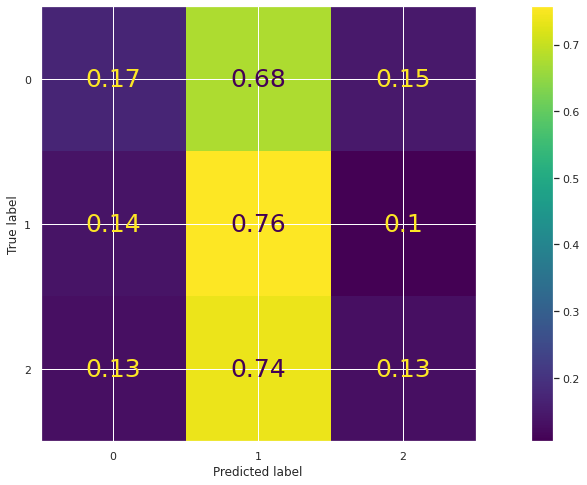

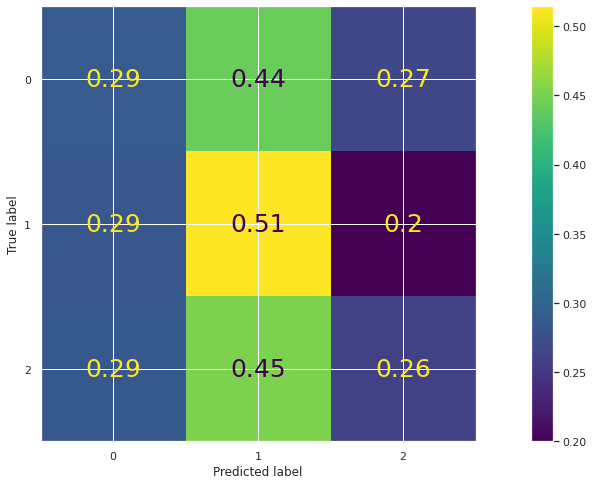

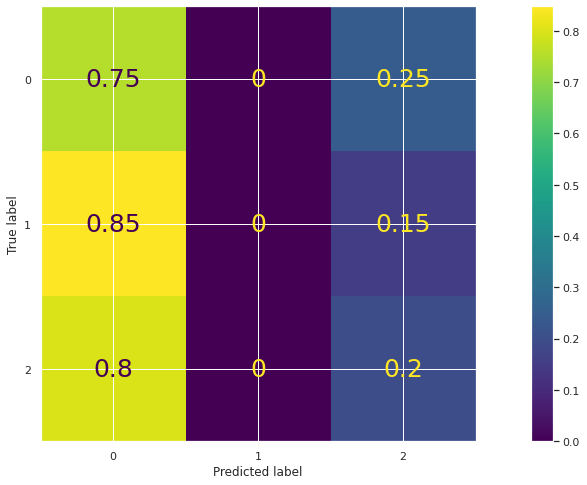

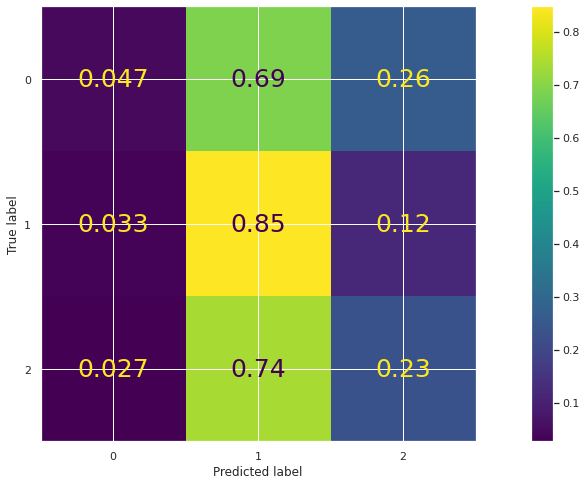

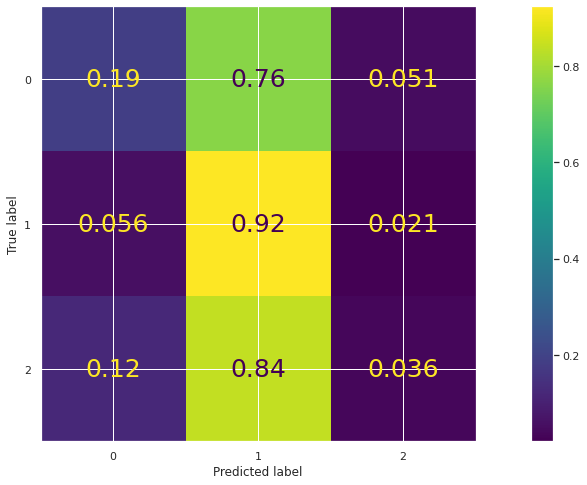

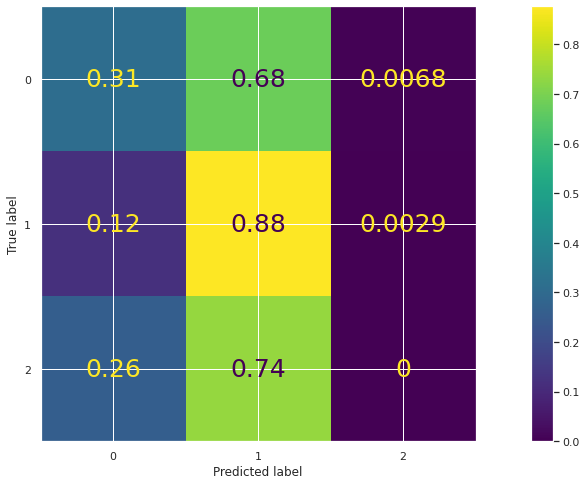

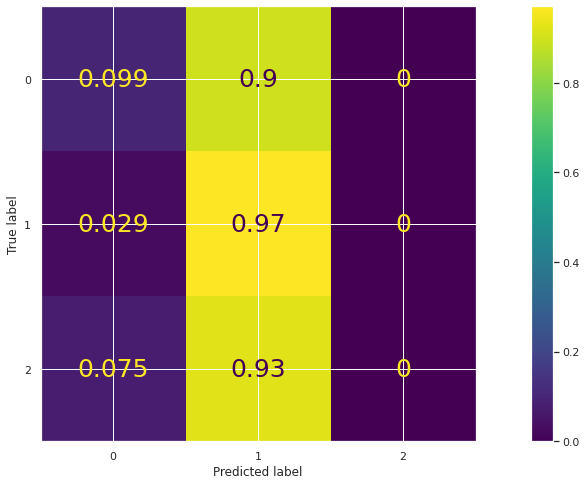

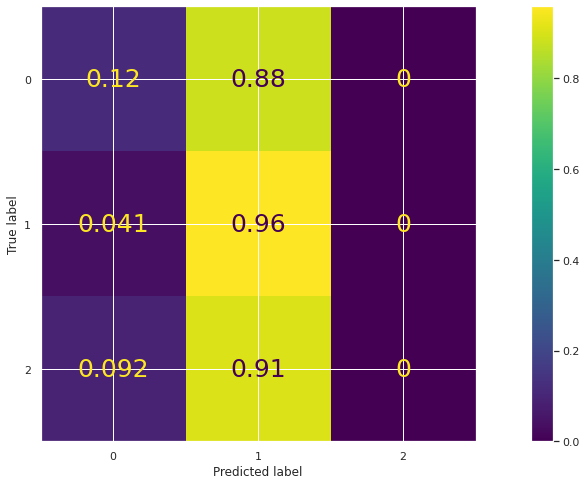

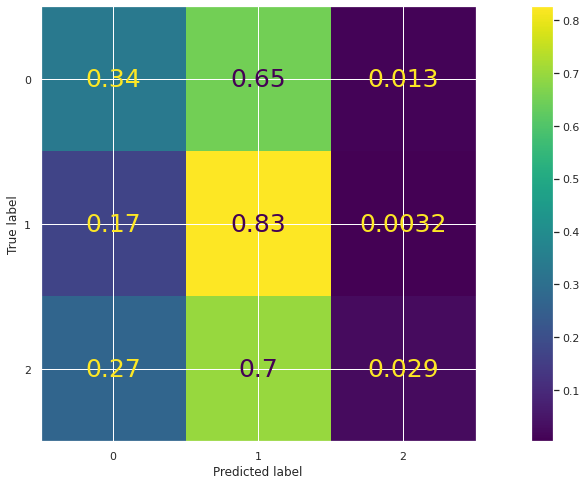

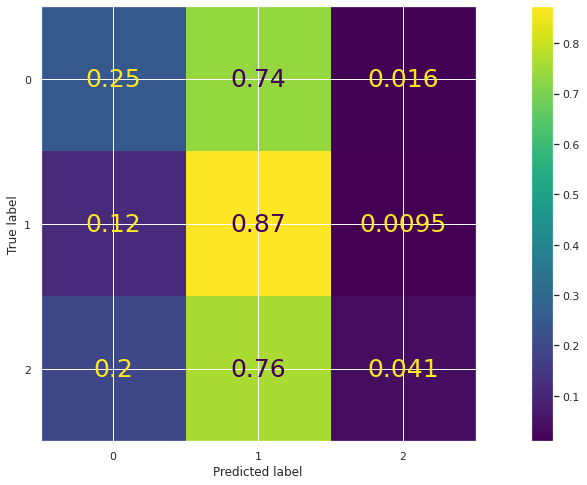

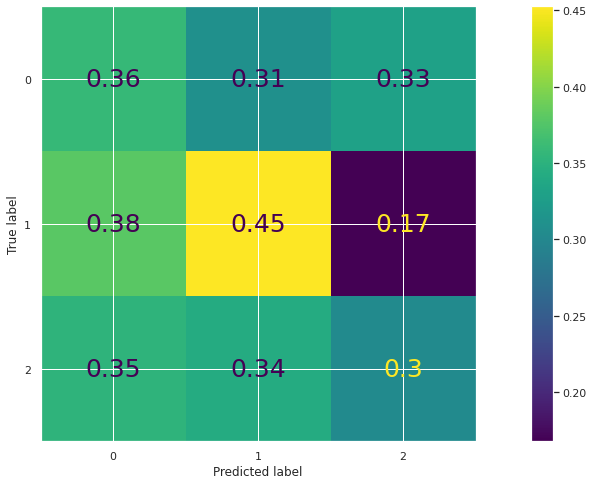

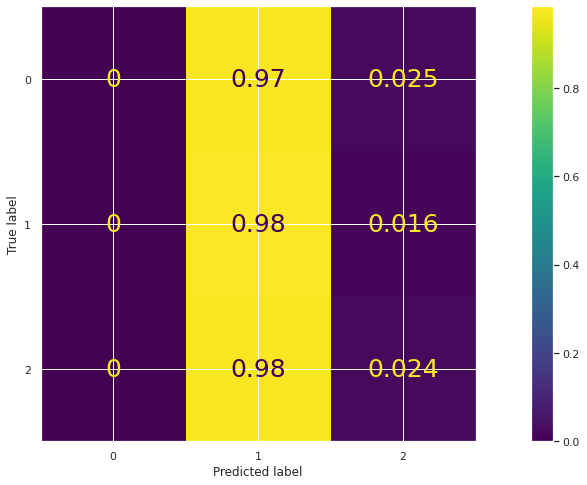

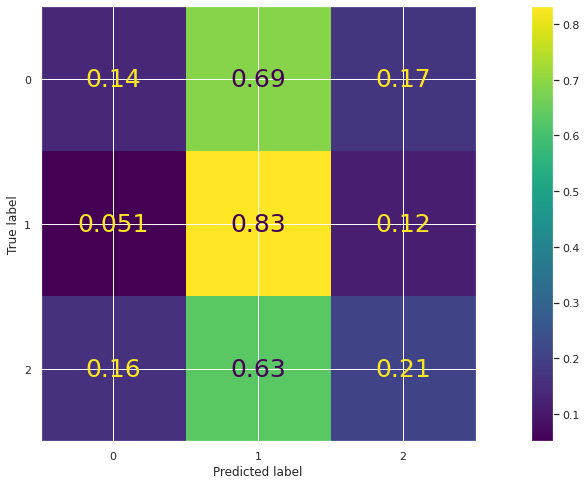

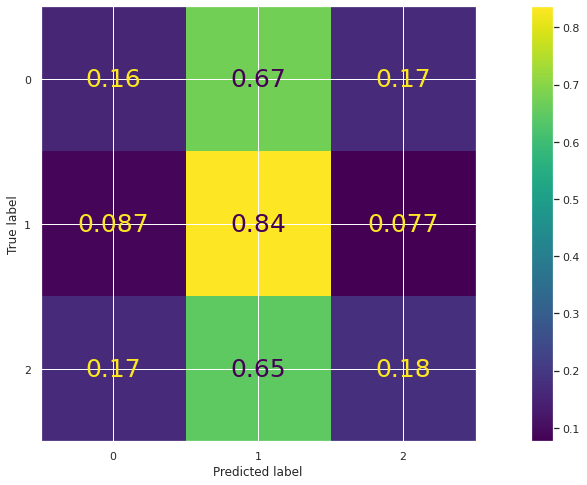

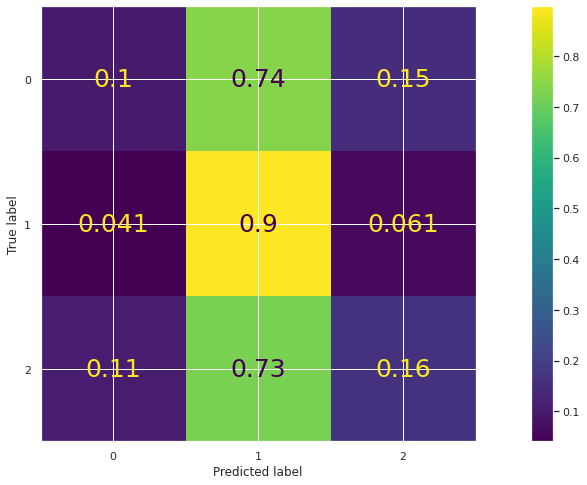

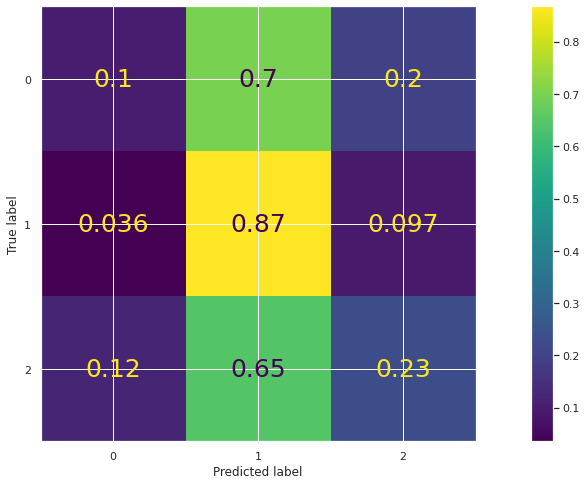

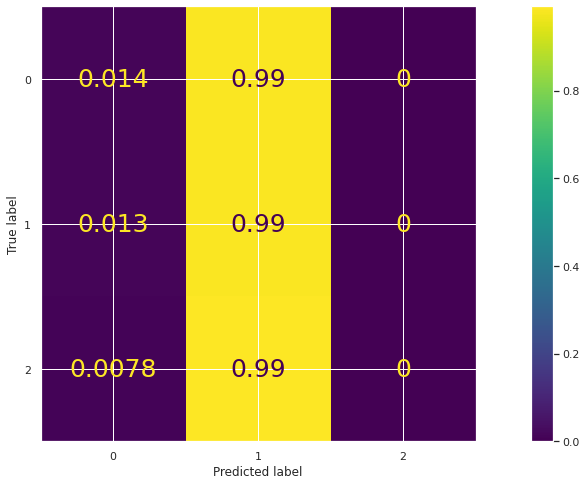

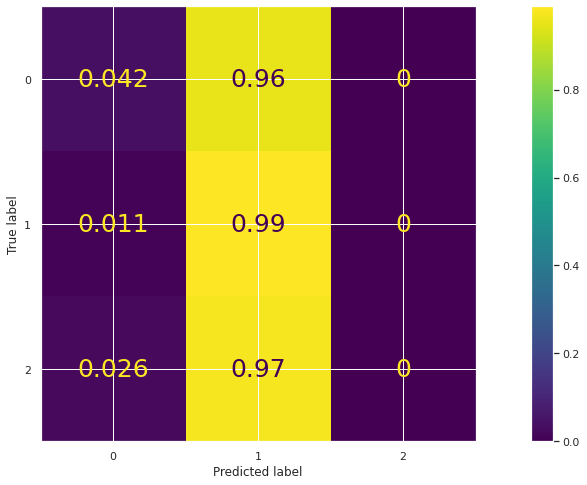

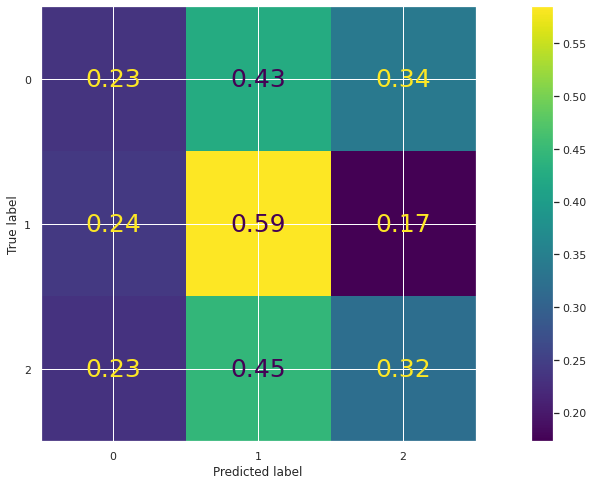

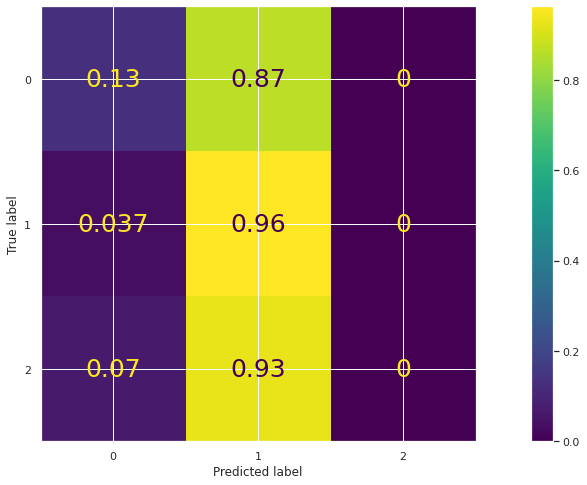

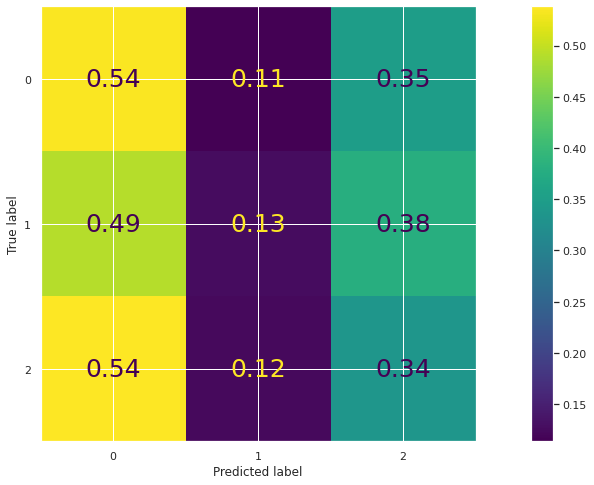

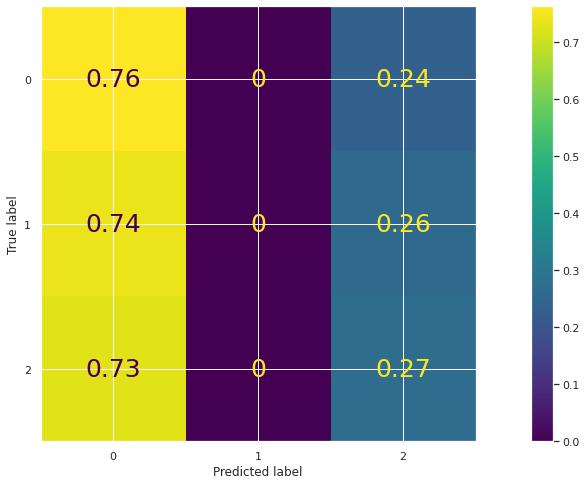

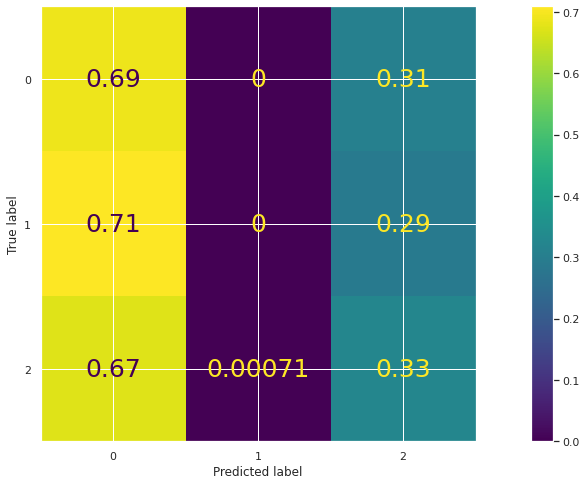

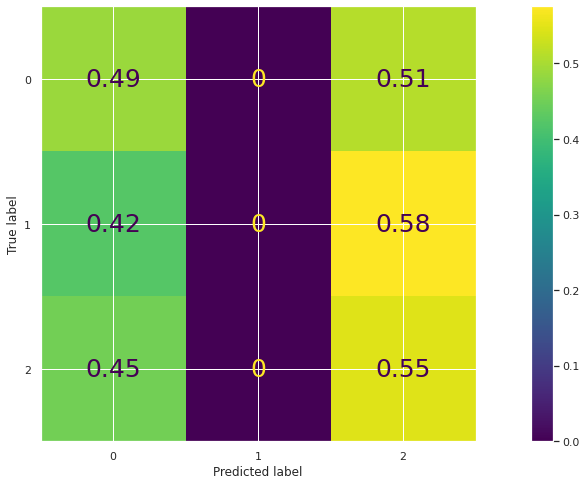

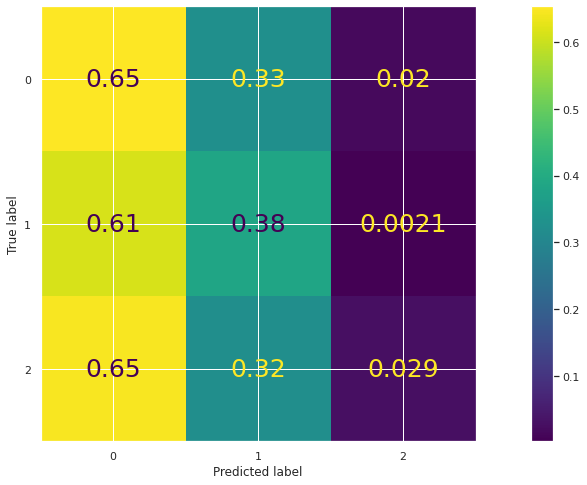

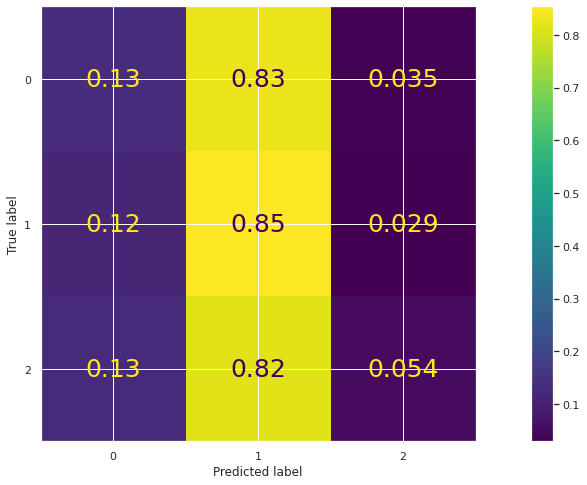

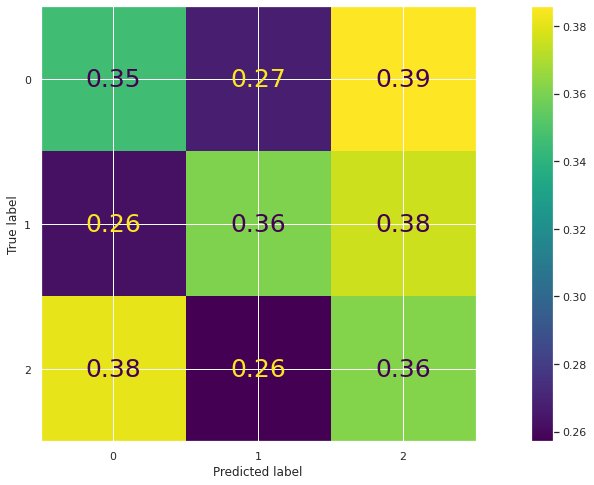

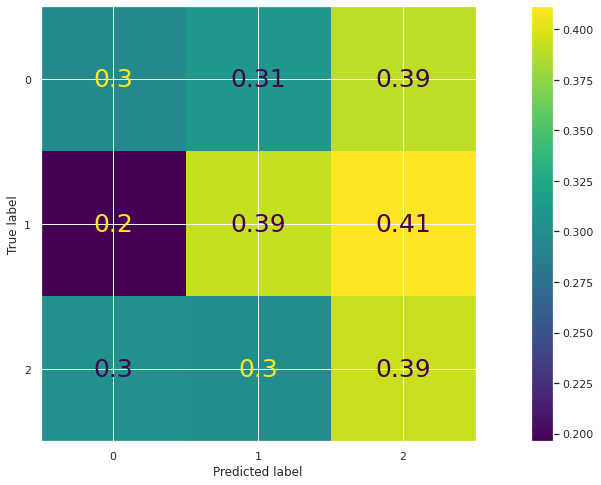

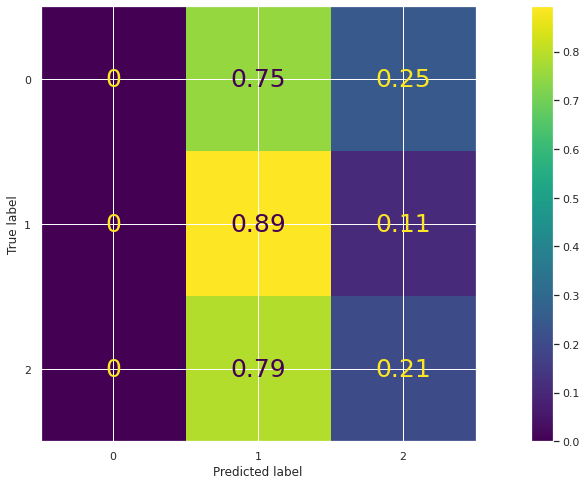

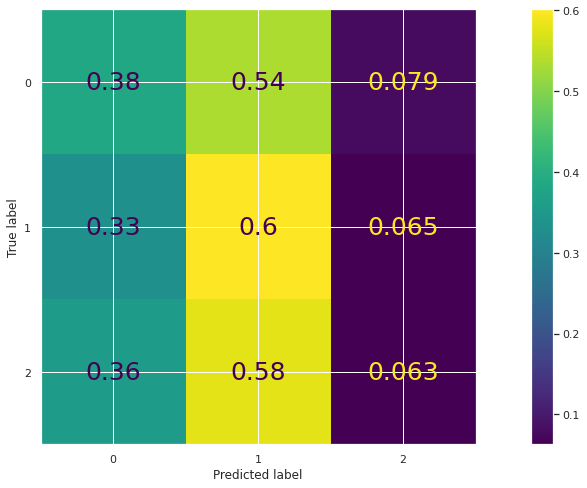

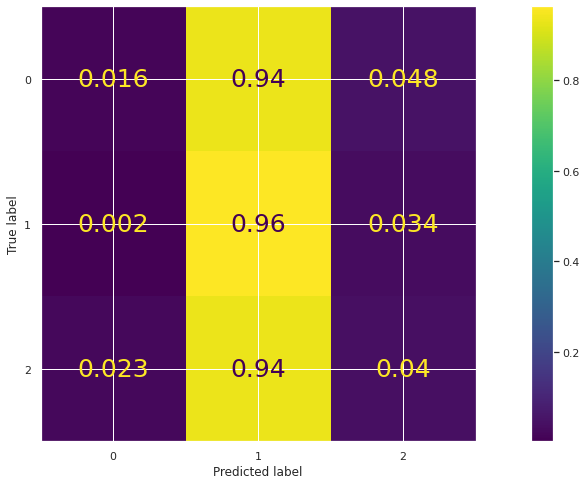

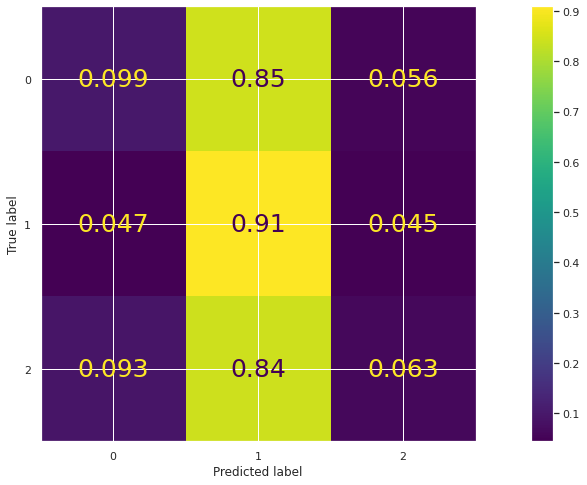

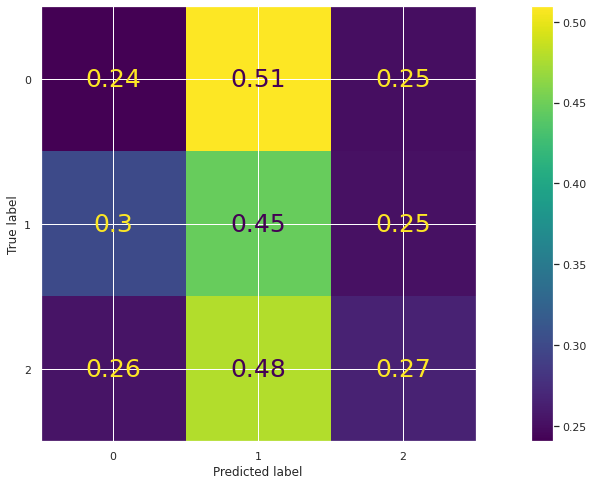

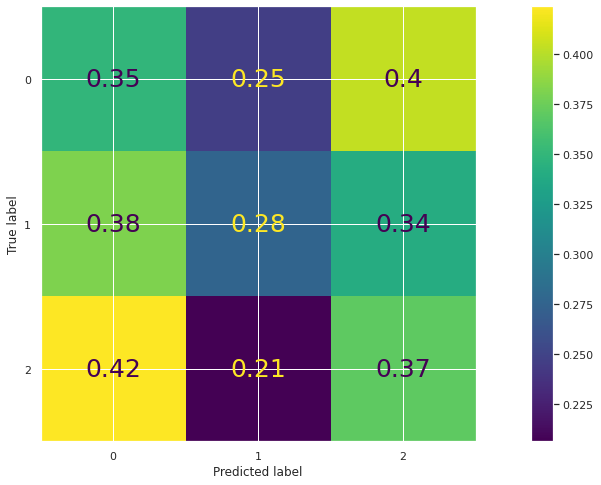

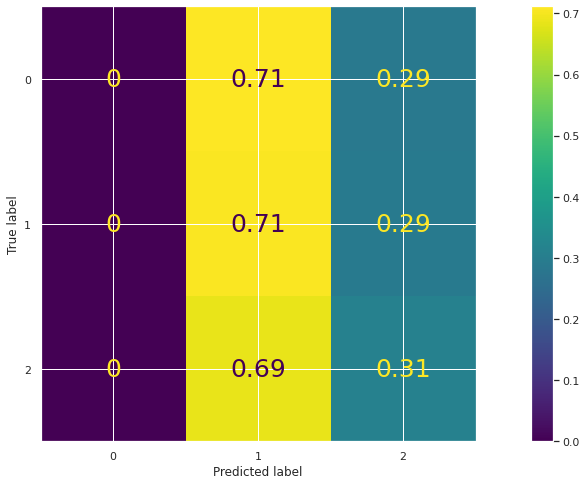

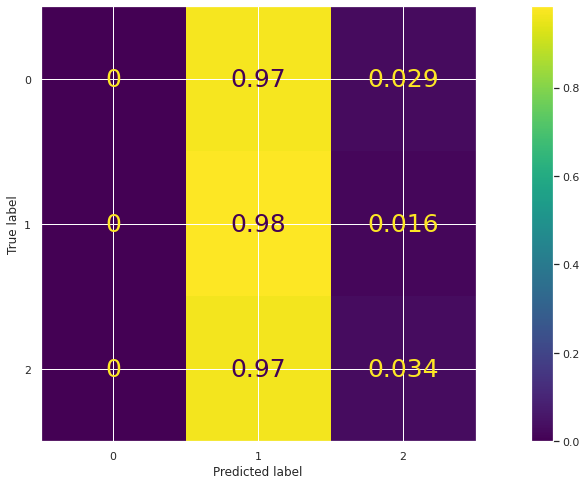

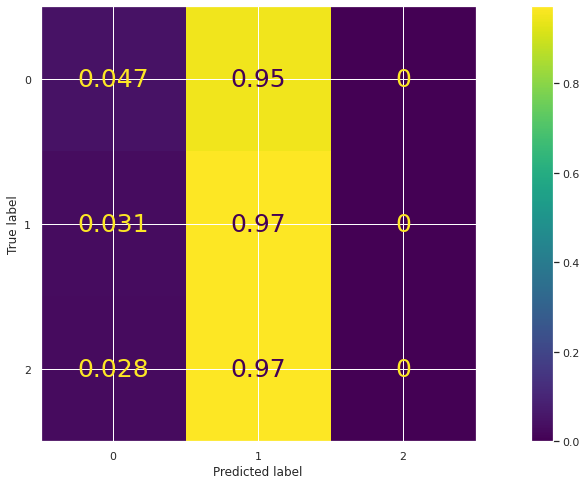

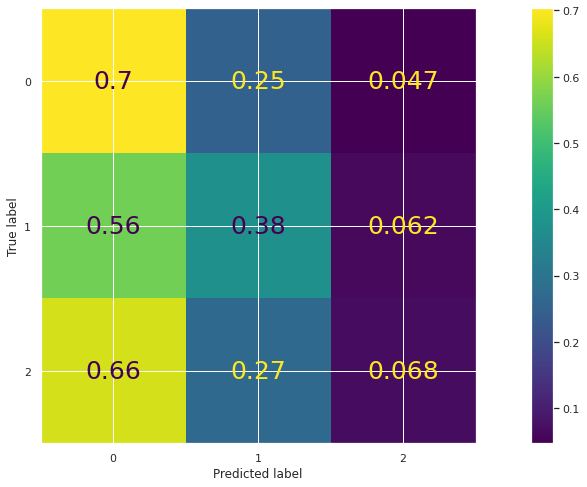

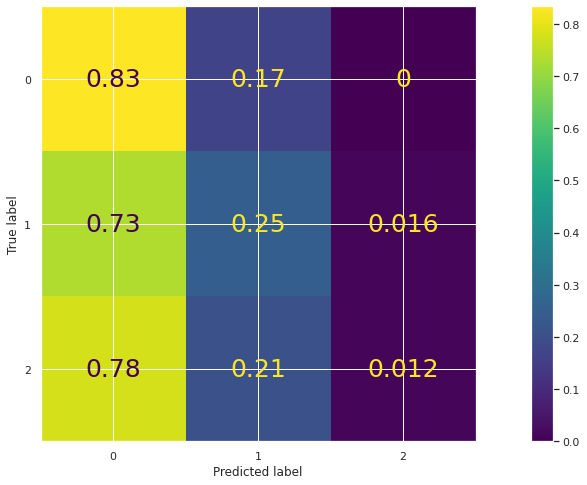

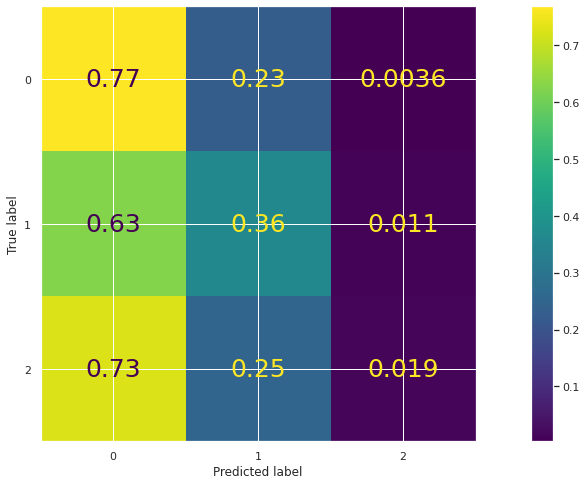

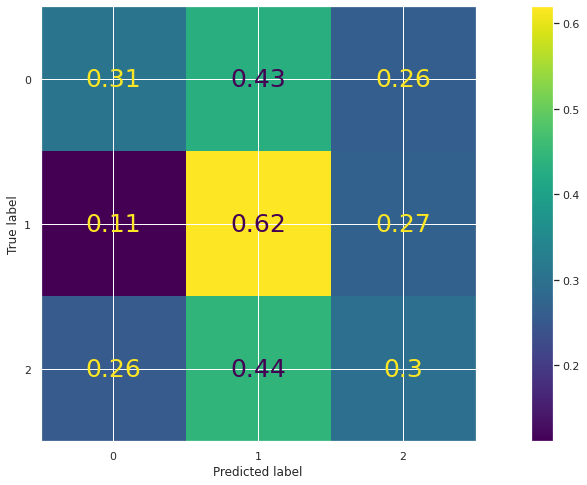

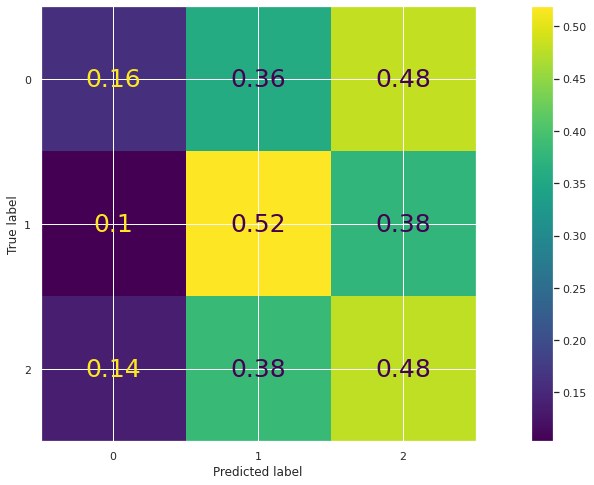

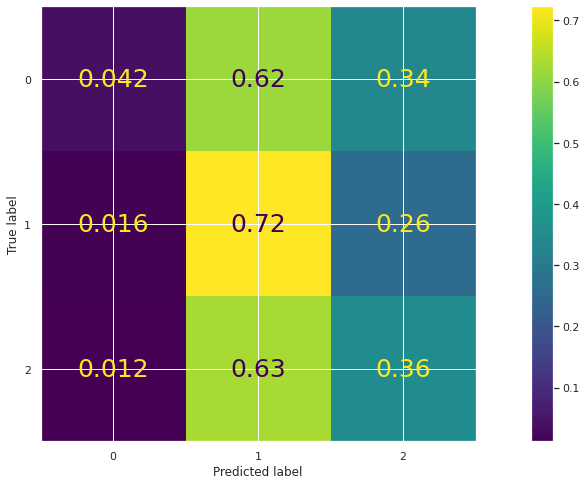

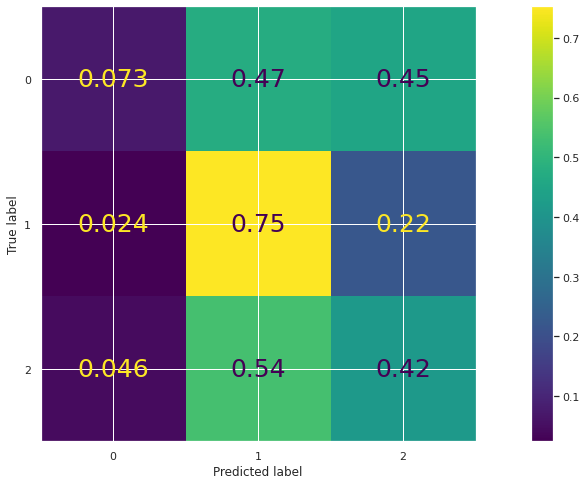

In [26]:
quotations = ['AAL', 'AAPL', 'AMZN', 'GM', 'GOOG', 'IBM', 'JNJ', 'KO', 'TSLA', 'WMT', 'XOM']
quot_metrics_dict = {}
for quot in quotations:
    data_wrapper = StocksDataWrapper.read_from(f"{DATA_PATH}{quot}{FILE_SUFFIX}", compute_features=True, predict_n=1, thresh_diff=0.005, normalize=True)
    data_columns = ['Close', 'PercentageDiff', f"RSI(14)", 'Volume', 'LowLen']

    X_train, X_test, y_train, y_test = data_wrapper.get_datasets(n_splits=1, val_size=0.3, 
                                                                 y_column='Next', 
                                                                 features_list=data_columns)
    

    USE_CLASS_WEIGHTS = True

    if USE_CLASS_WEIGHTS:
        class_weights=compute_class_weights(y_train)
    else:
        class_weights = None
        
    PERFORM_GRID_SEARCH = True
    
    
    if PERFORM_GRID_SEARCH:
        best_params = compute_grid_search(param_grid, X_train)
        print(best_params)
        
    clf_dict = {}

    clf_dict['DTree'] = DecisionTreeClassifier(**best_params['DTree'], random_state=42, class_weight=class_weights)
    clf_dict['RandomForest'] = RandomForestClassifier(**best_params['RandomForest'], random_state=42, class_weight=class_weights)
    clf_dict['SVM'] = SVC(**best_params['SVM'], class_weight=class_weights)
    clf_dict['LR'] = LogisticRegression(**best_params['LR'], class_weight=class_weights)
    
    quot_metrics_dict[quot] = train_evaluate_classifiers(clf_dict, X_train, y_train, X_test, y_test)

In [34]:
#print(quot_metrics_dict)

for quot, classifiers in quot_metrics_dict.items():
    print(f"[{quot}]")
    for label, metrics in classifiers.items():
        print(f"\t[{label}] : acc :  {metrics['acc']:.2f}, f1 : {metrics['f1']:.2f}")
    
    print("\n")


[AAL]
	[DTree] : acc :  0.27, f1 : 0.30
	[RandomForest] : acc :  0.32, f1 : 0.32
	[SVM] : acc :  0.39, f1 : 0.46
	[LR] : acc :  0.28, f1 : 0.34


[AAPL]
	[DTree] : acc :  0.37, f1 : 0.47
	[RandomForest] : acc :  0.37, f1 : 0.48
	[SVM] : acc :  0.34, f1 : 0.48
	[LR] : acc :  0.34, f1 : 0.47


[AMZN]
	[DTree] : acc :  0.36, f1 : 0.45
	[RandomForest] : acc :  0.35, f1 : 0.44
	[SVM] : acc :  0.37, f1 : 0.37
	[LR] : acc :  0.31, f1 : 0.45


[GM]
	[DTree] : acc :  0.34, f1 : 0.39
	[RandomForest] : acc :  0.34, f1 : 0.39
	[SVM] : acc :  0.33, f1 : 0.40
	[LR] : acc :  0.35, f1 : 0.40


[GOOG]
	[DTree] : acc :  0.36, f1 : 0.52
	[RandomForest] : acc :  0.37, f1 : 0.52
	[SVM] : acc :  0.39, f1 : 0.40
	[LR] : acc :  0.38, f1 : 0.51


[IBM]
	[DTree] : acc :  0.31, f1 : 0.34
	[RandomForest] : acc :  0.31, f1 : 0.40
	[SVM] : acc :  0.30, f1 : 0.39
	[LR] : acc :  0.32, f1 : 0.39


[JNJ]
	[DTree] : acc :  0.34, f1 : 0.38
	[RandomForest] : acc :  0.44, f1 : 0.53
	[SVM] : acc :  0.36, f1 : 0.35
	[LR] : a

In [42]:
metrics_df = pd.DataFrame.from_dict(quot_metrics_dict).T
acc_df = metrics_df.applymap(lambda metrics: metrics['acc'])
f1_df = metrics_df.applymap(lambda metrics: metrics['f1'])

,DTree,RandomForest,SVM,LR
AAL,0.301277,0.321363,0.459990,0.336930
AAPL,0.466715,0.478772,0.477954,0.474359
AMZN,0.446357,0.440080,0.365806,0.454651
GM,0.390377,0.389548,0.397090,0.404204
GOOG,0.519786,0.520894,0.402569,0.513409
IBM,0.338034,0.397581,0.385423,0.392901
JNJ,0.382719,0.530548,0.348740,0.363849
KO,0.581318,0.429501,0.610106,0.573515
TSLA,0.268004,0.340392,0.293207,0.267617
WMT,0.576961,0.402691,0.399294,0.419592


<AxesSubplot:>

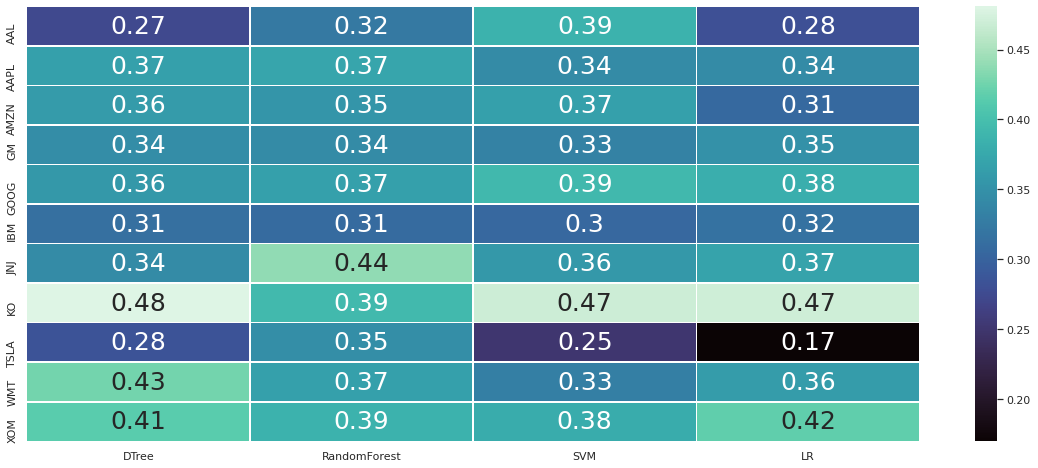

In [48]:
sns.heatmap(acc_df, cmap ='mako', linewidths = 0.5, annot = True)

|--- Volume <= 0.04
|   |--- class: 1
|--- Volume >  0.04
|   |--- class: 0



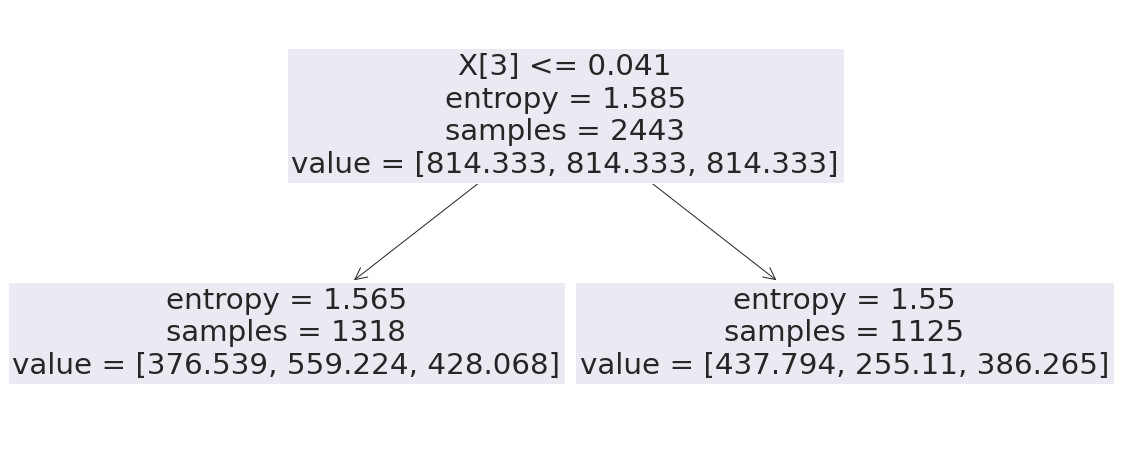

In [93]:
from sklearn import tree
from sklearn.tree import export_text
dtree = clf_dict['DTree']

#print(dtree.feature_importances_)
tree.plot_tree(dtree)

#print(dtree.tree_.feature)



rules = export_text(dtree, feature_names=(data_columns))

print(rules)